In [1]:
import itertools
import numpy as np
import numpy.random as npr
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors
from matplotlib import gridspec
import matplotlib

import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D  

import scipy.io
from scipy.io import loadmat
from scipy.io import savemat
from scipy import stats
from scipy.special import softmax
from sklearn.metrics import log_loss
import pickle
import copy

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.family':'Arial'})

## Read Data

In [6]:
subjectNames = ['sam','tabitha','chloe','blanche','b01','b02','b03','b04','b05','b06','b07','b08','b09','b10']

numSubjects = len(subjectNames)

stateNames = ['Persist','Preferred','Random','Avoid']
historyNames = ['(0,0)','(1,0)','(0,1)','(1,1)']

speciesList = np.array([0,0,0,0,1,1,1,1,1,2,2,2,2,2])

speciesColor = ['#fb8072','#8dd3c7','#74add1']
speciesDColor = ['#6a0e03','#1d4c44','#183649']
catColor = [np.array([152,78,163])/255, np.array([77,175,74])/255]
speciesNameLeg = ['Monkeys','Human DS1', 'Human DS2']

speciesNames = ['monkey','human','human2']

def getPM(N):
    if N == 1:
        return 1
    elif N > 1:
        x = np.zeros([N])
        x[0] = 1
        for i in np.arange(1,N):
            x[i] = -1 * x[i-1]
        return x

######################################

analysis = []
data = []
data0 = []


for i in range(numSubjects):
    with open('analysis/'+subjectNames[i]+'.pickle', 'rb') as f:
        [A] = pickle.load(f)
    analysis.append(A)
    with open('data/'+subjectNames[i]+'.pickle', 'rb') as f:
        [D] = pickle.load(f)
    data.append(D)
    data0.append(D)


categoryNames = ['Perseveration',
                 'Random search',
                 'Non-rule \n exploration',
                 'Rule favored, \n exploration',
                 'Rule preferred',
                 'Rule exploitation']

subjectNames = ['1','2','3','4','1','2','3','4','5','1','2','3','4','5']



## Explanation for prolonged rule-favored exploration in monkeys

In [4]:
# Collect data
Lc = []
LcNonRule = []

for i in range(numSubjects):
    Lc.append(analysis[i]['categoryAnalysis']['LCategory'][3,:])
    Y = []
    X = analysis[i]['categoryAnalysis']['ellNonRuleExplore2']
    for j in range(len(X)):
        for k in range(len(X[j])):
            if len(X[j][k]) > 0:
                Y.append(np.array(X[j][k]))
    LcNonRule.append(np.concatenate(Y))

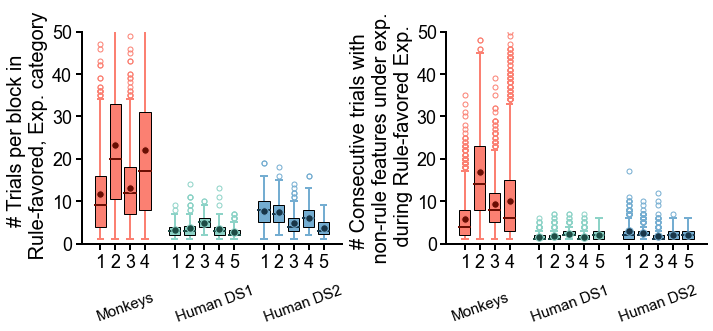

In [9]:
# Plot
fig, ax = plt.subplots(ncols=2,nrows=1,sharex=False,sharey=False,figsize=(4*2*1.4,3*1.3))

for p in range(2): # trials spent in rule-favored exploration vs. consecutive trials with non-rule features under exploration
    xPos = []

    pos = -0.8*2
    for spInd in range(3): # Species
        idx = np.where(np.array(speciesList) == spInd)[0]
        
        # Setup boxplot parameters
        prop1 = dict(color=speciesColor[spInd],linewidth=2)
        prop2 = dict(color=speciesDColor[spInd],linewidth=2)
        prop3 = dict(markeredgecolor=speciesColor[spInd],marker='.',markersize=10,linewidth=4)
        prop4 = dict(markerfacecolor=speciesDColor[spInd],
                     markeredgecolor=speciesColor[spInd],marker='.',markersize=15)

        pos += 0.8
        for i in idx: # Individuals

            pos += 0.8

            xPos.append(pos)
            if p == 0:
                dat = Lc[i]
            else:
                dat = LcNonRule[i]
            idx = np.where(dat > 0)[0]
            bp = ax[p].boxplot(dat[idx],positions=[pos],widths=0.6,patch_artist=True,medianprops=prop2,whiskerprops=prop1,
                            capprops=prop1,flierprops=prop3,zorder=0,showmeans=True,meanprops=prop4)

            bp['boxes'][0].set_facecolor(speciesColor[speciesList[i]])
            
        fig.text(0.18+0.11*spInd+p*0.44, -0.15, speciesNameLeg[spInd], ha='center', size=15,rotation=20)


    # Prettify
    ax[p].set_xlim([xPos[0]-1,xPos[-1]+1])
    ax[p].set_ylim([0,50])
    ax[p].set_xticks(xPos)
    ax[p].set_xticklabels(subjectNames,fontsize=18) #,rotation=30

#     ax[p].text(1.5, -7, 'Monkeys', ha='center', size=20)
#     ax[p].text(6.8, -7, 'Humans', ha='center', size=20)
    # fig.text(0.5, -0.25, 'N = '+str(Lc5Sim[0].shape[0])+' simulations', ha='center', size=12)

    if p == 0:
        ax[p].set_ylabel('# Trials per block in \n Rule-favored, Exp. category',fontsize=20)
    else:
        ax[p].set_ylabel('# Consecutive trials with \n non-rule features under exp. \n during Rule-favored Exp.',fontsize=20)        

    ax[p].tick_params(axis='both',direction='out',width=2)
    ax[p].tick_params(axis='x',length=6,labelsize=18)
    ax[p].tick_params(axis='y',length=6,labelsize=18)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[p].spines[axis].set_linewidth(2)

    ax[p].spines['right'].set_visible(False)
    ax[p].spines['top'].set_visible(False)

    ax[p].set_axisbelow(True)
    
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.0)

# plt.savefig('figures/fig7/longRuleFavExpEvd.eps', format='eps')

## Breakdown for excessive number of trials exploiting the rule and one or more other features by monkeys

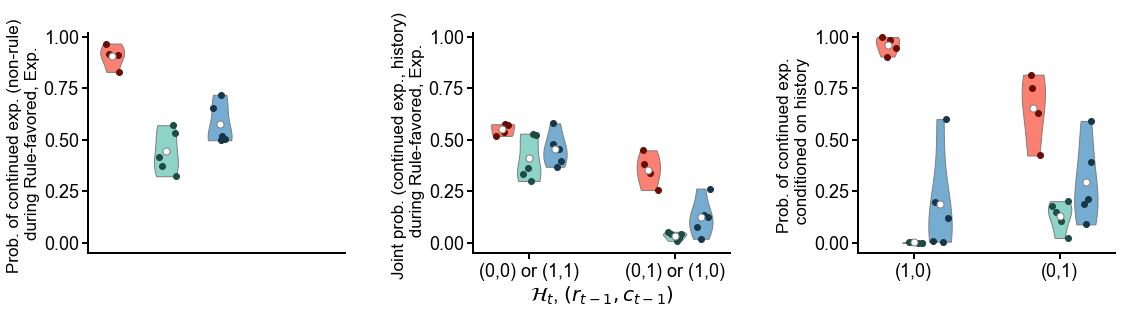

In [14]:
# Collect data and compute measures
Dat = dict()
Dat[0] = np.zeros((len(analysis))) # Probability of continued exploration
Dat[1] = np.zeros((len(analysis),2)) # Joint probability of continued exploration (with history)
Dat[2] = np.zeros((len(analysis),2)) # Probability of continued exploration conditioned on history
Dat[3] = np.zeros((len(analysis),2)) # Probability of history under continued exploration
for i in range(len(analysis)):
    D = np.zeros((4,5))
    X = np.around(analysis[i]['categoryAnalysis']['stateNonRuleExplore']['pz_S0C'],3)
    X[np.isnan(X)] = 0
    D[:2,0] = X[0] # conditional probability of exploration
    X = np.around(analysis[i]['categoryAnalysis']['stateNonRuleExplore']['pH_S0C'],3)
    X[np.isnan(X)] = 0
    D[:4,1] = X # conditional probability of history
    X = np.around(analysis[i]['categoryAnalysis']['stateNonRuleExplore']['pz_HS0C'],3)
    X[np.isnan(X)] = 0
    D[:4,3] = np.around(X[0,:],3) # conditional probability of exploration (also conditioned on history)
    y1 = np.multiply(D[:4,1],D[:4,3])
    Dat[0][i] = np.around(np.sum(y1),3) # conditional probability of exploration
    Dat[1][i,0] = np.around(np.sum(y1[[0,3]]),3) # positive feedback history (direct and indirect)
    Dat[1][i,1] = np.around(np.sum(y1[[1,2]]),3) # negative feedback history (direct and indirect)
    Dat[2][i,0] = np.around(D[1,3],3)  # conditioned on NC+
    Dat[2][i,1] = np.around(D[2,3],3) # conditioned on C-
    y1 = D[:4,1]
    Dat[3][i,0] = np.around(np.sum(y1[[0,3]]),3) # positive feedback history (direct and indirect)
    Dat[3][i,1] = np.around(np.sum(y1[[1,2]]),3) # negative feedback history (direct and indirect)


# Plot
fig, ax = plt.subplots(ncols=3,nrows=1,sharex=False,sharey=False,figsize=(4*2*2.3,3*1.35))#figsize=(4*2*3,3*2))

vpWidth = 0.5

for k in range(3): # quantities (to support explanation)
    dat = Dat[k]
    for i in np.unique(speciesList): # Species
        idx = np.where(np.array(speciesList) == i)[0]

        for j in range(dat.ndim): # breakdown unit
            if dat.ndim > 1:
                pdat = dat[idx,j]
            else:
                pdat = dat[idx]

            # Violins
            vp = ax[k].violinplot(pdat,[j*2.5+(i+i*(2-dat.ndim))*0.45],showextrema=False,widths=vpWidth*0.8)
            for pc in vp['bodies']:
                pc.set_facecolor(speciesColor[i])
                pc.set_edgecolor('gray')
                pc.set_alpha(1)

            # Points
            x = npr.rand(idx.shape[0]) * (vpWidth) * (0.3)
            pm = getPM(idx.shape[0])
            x = np.multiply(x,pm)+j*2.5+(i+i*(2-dat.ndim))*0.45+0.025

            ax[k].scatter(x,pdat,color=speciesDColor[i])
            ax[k].scatter(j*2.5+(i+i*(2-dat.ndim))*0.45,np.mean(pdat),color='white',s=50,edgecolors='gray')

    # Prettify
    ax[k].set_ylim([-0.05,1.02])
    if k == 0:
        ax[k].set_xlim([-0.4,3.9])
        ax[k].set_xticks([])
    else:
        ax[k].set_xlim([-0.5,3.9])
        ax[k].set_xticks([0.45,2.95])
        if k == 1:
            ax[k].set_xticklabels(['(0,0) or (1,1)','(0,1) or (1,0)'],fontsize=18)
        else:
            ax[k].set_xticklabels(['(1,0)','(0,1)'],fontsize=18)

    ax[k].set_yticks([0,0.25,0.5,0.75,1])

    if k == 0:
        ax[k].set_ylabel('Prob. of continued exp. (non-rule) \nduring Rule-favored, Exp.',fontsize=17)
    elif k == 1:
        ax[k].set_ylabel('Joint prob. (continued exp., history) \n during Rule-favored, Exp.',fontsize=17)
    else:
        ax[k].set_ylabel('Prob. of continued exp. \n conditioned on history',fontsize=17)


    if k == 1:
        ax[k].set_xlabel('$\mathcal{H}_t$, $(r_{t-1},c_{t-1})$',fontsize=20)

    ax[k].tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[k].spines[axis].set_linewidth(2)

    ax[k].spines['right'].set_visible(False)
    ax[k].spines['top'].set_visible(False)

plt.subplots_adjust(wspace=0.5,
                    hspace=0.0)
# plt.savefig('figures/fig7/longRuleFavExpCause.eps', format='eps')

### Statistical testing

In [15]:
# Helper bootstrap
def calcBootstrp(data1, data2):
    data1 = np.array(data1)
    data2 = np.array(data2)
    s = stats.ttest_ind(data1, data2, equal_var=False)
    t = s.statistic

    data1_hat = data1-np.mean(data1) + np.mean(np.concatenate([data1, data2]))
    data2_hat = data2-np.mean(data2) + np.mean(np.concatenate([data1, data2]))
    t_stars = []
    for i in range(10000):
        data1_samp = np.random.choice(data1_hat,size=data1.shape[0])
        data2_samp = np.random.choice(data2_hat,size=data2.shape[0])
        s = stats.ttest_ind(data1_samp, data2_samp, equal_var=False)
        t_stars.append(s.statistic)

    return t, t_stars

In [18]:
# Under NC+
hmn = Dat[2][4:9,0]
hmn2 = Dat[2][9:,0]
mmn = Dat[2][:4,0]
t, t_stars = calcBootstrp(hmn,mmn)
t2, t_stars2 = calcBootstrp(hmn2,mmn)
print('NC+ : ' + str([np.mean(t_stars<=t),np.mean(t_stars2<=t2)]))

# Under C-
hmn = Dat[2][4:9,1]
hmn2 = Dat[2][9:,1]
mmn = Dat[2][:4,1]
t, t_stars = calcBootstrp(hmn,mmn)
t2, t_stars2 = calcBootstrp(hmn2,mmn)
print('C- : ' + str([np.mean(t_stars<=t),np.mean(t_stars2<=t2)]))

NC+ : [0.0021, 0.0149]
C- : [0.0054, 0.0352]


## Number of trials exploring non-rule feature in rule-favored exploration and non-rule-exploration

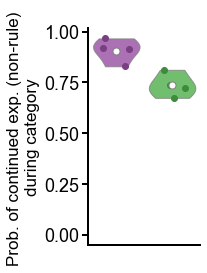

In [24]:
# Collect data
Dat = np.zeros([4,2])
idx = np.where(np.array(speciesList) == 0)[0] # monkeys only
for k in idx:
    X = np.sum(analysis[k]['categoryAnalysis']['catEndReasStats'],0)#[5],0)
    X = X/np.sum(X)
    Dat[k,0] = X[0]
    X = np.sum(analysis[k]['categoryAnalysis']['catEndReasStats2'],0)#[5],0)
    X = X/np.sum(X)
    Dat[k,1] = X[0]


# Plot
fig, ax = plt.subplots(ncols=1,nrows=1,sharex=False,sharey=False,figsize=(2,4))

vpWidth = 0.5


for i in range(2): # categories
    dat = Dat[:,i]
    
    # Violins
    vp = ax.violinplot(dat,[i*0.6],showextrema=False,widths=vpWidth)
    for pc in vp['bodies']:
        pc.set_facecolor(catColor[i])
        pc.set_edgecolor('gray')
        pc.set_alpha(0.8)

    # Points
    x = npr.rand(4) * (vpWidth) * (0.3)
    pm = getPM(4)
    x = np.multiply(x,pm)+i*0.6

    ax.scatter(x,dat,color=catColor[i]*0.8)
    ax.scatter(i*0.6,np.mean(dat),color='white',s=50,edgecolors='gray')

# Prettify
ax.set_ylim([-0.05,1.02])
ax.set_xlim([-0.3,0.9])
ax.set_yticks([0,0.25,0.5,0.75,1.0])
ax.set_xticks([])

ax.set_ylabel('Prob. of continued exp. (non-rule) \nduring category',fontsize=17)

ax.tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('figures/fig7/transProb_Cat3.eps', format='eps')

## Breakdown for difference in # trials exploring non-rule feature during the two trial categories by monkeys

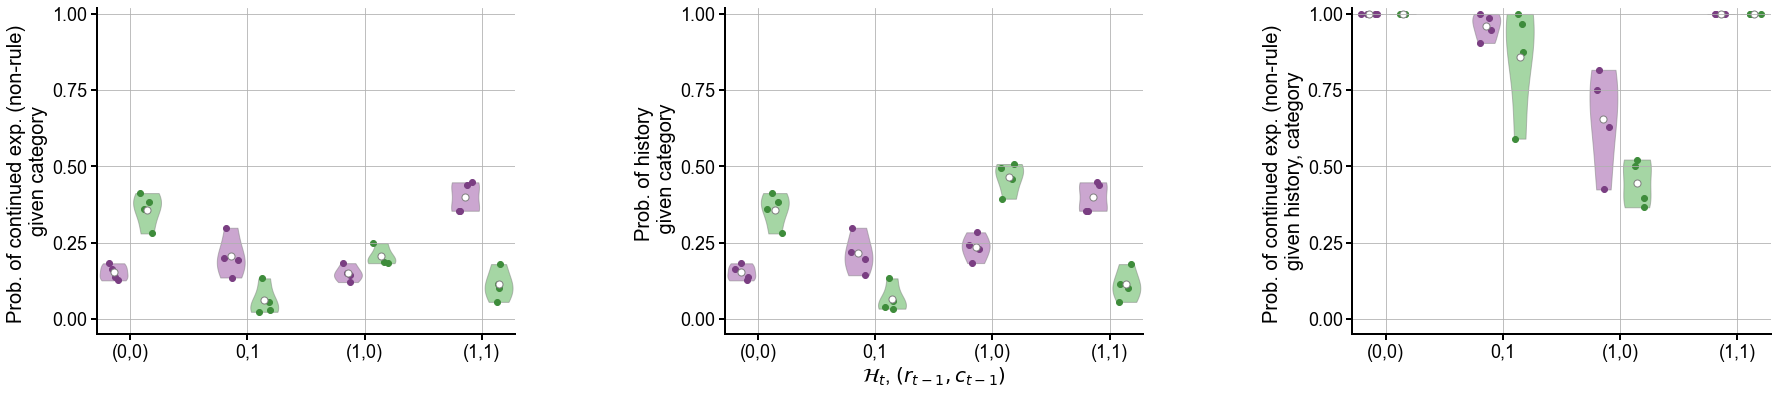

In [30]:
# Collect data and compute measures
Dat = dict()
idx = np.where(np.array(speciesList) == 0)[0] # monkeys only
Dat[0] = np.zeros([2*idx.size,4])
Dat[1] = np.zeros([2*idx.size,4])
Dat[2] = np.zeros([2*idx.size,4])
for l in range(2): # Category
    for k in idx: # subjects
        if l == 0:
            D = analysis[k]['categoryAnalysis']['catEndReasStats']#[5]
        else:
            D = analysis[k]['categoryAnalysis']['catEndReasStats2']#[5]

        D = D/np.sum(D) # joint prob cont. exploration, history | category
        Dat[0][k+l*4,:] = D[:,0]
        Y = np.sum(D,1,keepdims=True) # prob of hist, given category
        Dat[1][k+l*4,:] = Y[:,0]
        # prob exp, given history and cont. explore
        # X[np.isnan(X)] = 0
        Dat[2][k+l*4,:] = D[:,0]/Y[:,0]

# Plot
fig, ax = plt.subplots(ncols=3,nrows=1,sharex=False,sharey=False,figsize=(4*2.5*3,3*2))

vpWidth = 0.5

for k in range(3): # subplots
    for m in range(4): # histories
        D1 = []
        D2 = []
        for i in range(2): # categories
            didx = np.arange(idx.size) + i*idx.size
            dat = Dat[k][didx,m]
            
            # Violins
            vp = ax[k].violinplot(dat,[i*0.6+m*2.1],showextrema=False,widths=vpWidth)
            for pc in vp['bodies']:
                pc.set_facecolor(catColor[i])
                pc.set_edgecolor('gray')
                pc.set_alpha(0.5)

            # Points
            x = npr.rand(didx.shape[0]) * (vpWidth) * (0.3)
            pm = getPM(didx.shape[0])
            x = np.multiply(x,pm)+i*0.6+m*2.1

            ax[k].scatter(x,dat,color=catColor[i]*0.8)
            ax[k].scatter(i*0.6 +m*2.1,np.mean(dat),color='white',s=50,edgecolors='gray')  

    # Prettify
    ax[k].set_ylim([-0.05,1.02])
    ax[k].set_xlim([-0.3,7.2])
    ax[k].set_xticks([0.3,2.4,4.5,6.6])
    ax[k].set_yticks([0,0.25,0.5,0.75,1.0])
    ax[k].set_xticklabels(['(0,0)','0,1', '(1,0)','(1,1)'],fontsize=18)
    if k == 0:
        ax[k].set_ylabel('Prob. of continued exp. (non-rule) \ngiven category',fontsize=20)
    elif k == 1:
        ax[k].set_ylabel('Prob. of history \n given category',fontsize=20)
    else:
        ax[k].set_ylabel('Prob. of continued exp. (non-rule) \ngiven history, category',fontsize=20)

    if k == 1:
        ax[k].set_xlabel('$\mathcal{H}_t$, $(r_{t-1},c_{t-1})$',fontsize=20)

    ax[k].tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[k].spines[axis].set_linewidth(2)

    ax[k].spines['right'].set_visible(False)
    ax[k].spines['top'].set_visible(False)
    ax[k].grid(which='major', axis='both')
    
plt.subplots_adjust(wspace=0.5, 
                    hspace=0.0)

# plt.savefig('figures/fig7/rewRtComp_2Cats.eps', format='eps')

### Statistical testing

In [28]:
mmnCat1 = Dat[1][4:,3]
mmnCat2 = Dat[1][:4,3]
t, t_stars = calcBootstrp(mmnCat1,mmnCat2)
print(np.mean(t_stars<=t))

0.0051
